In [77]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

In [78]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783K/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/NGC3783K',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783K/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = 8.997
MAG_HD101274_H = 8.982
MAG_HD101274_K = 8.909

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_B = 0.03
MAG_VEGA_V = 0.03
MAG_VEGA_G = 0.03
MAG_VEGA_J = -0.18
MAG_VEGA_H = -0.03
MAG_VEGA_K = 0.13

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

In [79]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [80]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [81]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [82]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [83]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [84]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":20, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':100, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [85]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 5. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 5. and \
            DECmain - 5. < out['table']['YMODEL_IMAGE'][j] < DECmain + 5.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [86]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN'])*data1_2*header['DIT']*header['NDIT']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['DIT']*header['NDIT'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['DIT']
                                                         *header['NDIT']
                                                         +header['NDIT']*npix1*header['RON']**2))

def SNR11(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT']))

def SNR22(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'])

def SNR33(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float((header['NDIT']*npix1*header['RON']**2))

def SNR44(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT'] + 
                  header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'] +
                  header['NDIT']*npix1*header['RON']**2))

#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

for i in range(len(quasJ)):
    data, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    #print header['CTYPE2']
    header['CTYPE1'] = "RA---TAN"
    header['CTYPE2'] = "DEC--TAN"
    header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [87]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),7))
    SNR_array = np.zeros((len(quas),8))
    SNR_part = np.zeros((len(quas),5))
    gain = []
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky)
        a_sky_2 = np.sum(a_sky)/float(np.count_nonzero(a_sky))
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        gain.append(header['gain'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson22.append(np.sqrt(np.sum(a3)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        poisson529.append(np.sqrt(np.sum(a4)*header['EXPTIME']*header['GAIN'])) #header['EXPTIME']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1 = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = date[i]
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = SNR1
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN,a2,a3
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,2] = SNR11(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,3] = SNR22(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,4] = SNR33(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    
    comp_array[:,1] = comp_array[:,1]*flux_cal(MAG_HD101274_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    comp_array[:,2] = comp_array[:,2]*flux_cal(MAG_TYCHO_2_7740_22_1_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    comp_array[:,3] = comp_array[:,3]*flux_cal(MAG_TYCHO_2_7740_529_1_K,MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta3)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,SNR_part

In [88]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1,SNR_part_1 = SEXAGNflux(quasJ,0.001)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/NGC3783K/2231.fits
1571.856 3004.361 nan
Frame nr.  1 /../home/lynge/MasterP/NGC3783/NGC3783K/2130.fits
4722.751 8635.605 nan
Frame nr.  2 /../home/lynge/MasterP/NGC3783/NGC3783K/1625.fits
4445.056 8040.662 1642.242
Frame nr.  3 /../home/lynge/MasterP/NGC3783/NGC3783K/1322.fits
4681.2 7977.539 1662.544
Frame nr.  4 /../home/lynge/MasterP/NGC3783/NGC3783K/2029.fits
3482.339 6366.361 1360.74
Frame nr.  5 /../home/lynge/MasterP/NGC3783/NGC3783K/8.fits
2504.388 3322.962 nan
Frame nr.  6 /../home/lynge/MasterP/NGC3783/NGC3783K/2332.fits
4841.639 8946.174 1904.856
Frame nr.  7 /../home/lynge/MasterP/NGC3783/NGC3783K/1120.fits
4492.524 7215.322 1496.912
Frame nr.  8 /../home/lynge/MasterP/NGC3783/NGC3783K/4.fits
7595.717 9446.132 2072.075
Frame nr.  9 /../home/lynge/MasterP/NGC3783/NGC3783K/2635.fits
5056.087 9426.008 nan
Frame nr.  10 /../home/lynge/MasterP/NGC3783/NGC3783K/211.fits
4659.14 6783.654 1384.78
Frame nr.  11 /../home/lynge/MasterP/NGC3

In [89]:
COMB = np.ndarray.tolist(ABS_FLUX_LAMBDA_1_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_2_1) + np.ndarray.tolist(ABS_FLUX_LAMBDA_3_1)
datelist = date_1 + date_1 + date_1

COMB_array = np.array((datelist,COMB))
print COMB_array[0,:]
np.savetxt('K-NGC3783',COMB_array)

np.savetxt('../NOVEMBER/NOV-NGC3783-K',comp_array)

[ 57554.220952    57562.09713     57701.353964    57726.346754
  57569.122646    57887.278044    57547.072674    57741.232156
  57925.061004    57516.044744    57817.193122    57949.0259175
  57918.05243     57711.36364333  57801.258766    57764.361732    57523.21773
  57864.1151025   57733.35946     57903.240258    57719.252584    57530.22185
  57749.286216    57809.371312    57598.999036    57878.226324
  57933.093792    57794.254554    57693.390664    57786.356042
  57583.997056    57894.990642    57757.236755    57772.342815
  57554.220952    57562.09713     57701.353964    57726.346754
  57569.122646    57887.278044    57547.072674    57741.232156
  57925.061004    57516.044744    57817.193122    57949.0259175
  57918.05243     57711.36364333  57801.258766    57764.361732    57523.21773
  57864.1151025   57733.35946     57903.240258    57719.252584    57530.22185
  57749.286216    57809.371312    57598.999036    57878.226324
  57933.093792    57794.254554    57693.390664    57786.

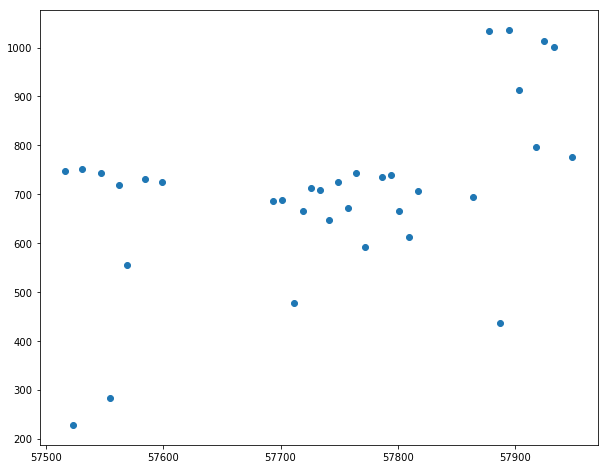

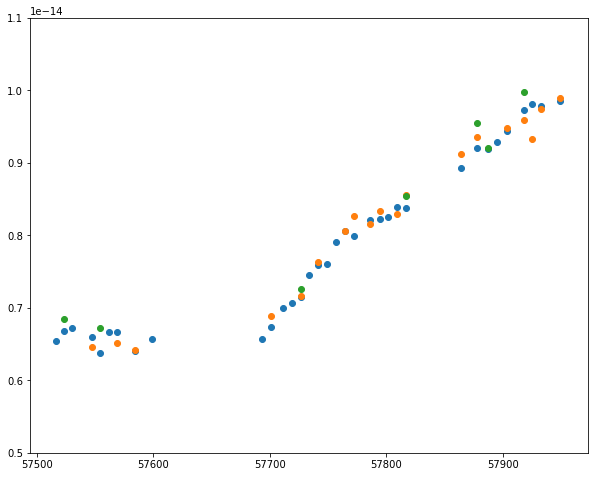

[  746.76916063   227.70345159   751.62758102   743.78918505   282.07611218
   719.02329851   555.44631073   730.31216922   725.13880753   686.69931389
   688.22762845   477.84093743   666.50456435   712.62643061   708.03911288
   648.21671434   725.80221971   671.43881452   744.00524991   591.19522569
   736.20036523   738.35911378   666.26684324   613.38647849   706.33081876
   693.55263578  1034.76416918   436.09083813  1036.7164077    912.35709316
   796.33295376  1012.94991052  1001.86564496   775.72704767]


In [90]:
plt.figure(figsize=(10,8))
plt.scatter(comp_array[:,0],comp_array[:,4])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(comp_array[:,0],comp_array[:,1])
plt.scatter(comp_array[:,0],comp_array[:,2])
plt.scatter(comp_array[:,0],comp_array[:,3])
plt.ylim([5*10**(-15),1.1*10**(-14)])
plt.show()

print comp_array[:,4]

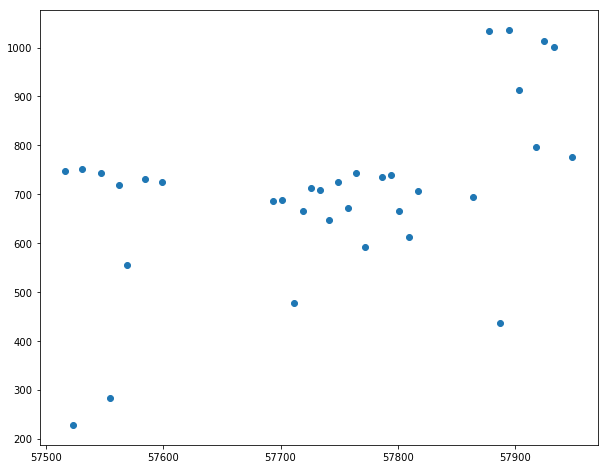

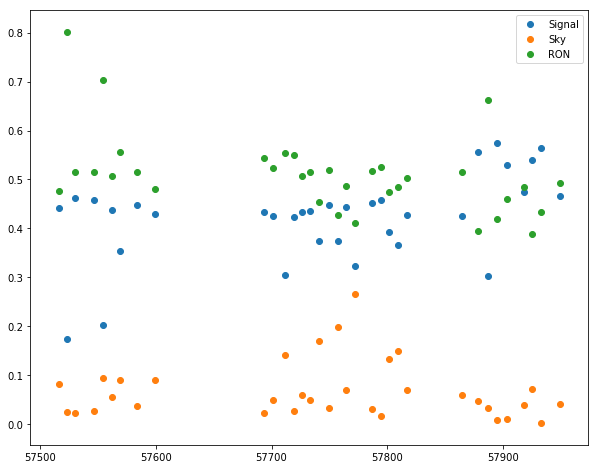

[ 57554.220952    57562.09713     57701.353964    57726.346754
  57569.122646    57887.278044    57547.072674    57741.232156
  57925.061004    57516.044744    57817.193122    57949.0259175
  57918.05243     57711.36364333  57801.258766    57764.361732    57523.21773
  57864.1151025   57733.35946     57903.240258    57719.252584    57530.22185
  57749.286216    57809.371312    57598.999036    57878.226324
  57933.093792    57794.254554    57693.390664    57786.356042
  57583.997056    57894.990642    57757.236755    57772.342815  ]


In [91]:
plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2],label='Signal')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3],label='Sky')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,4],label='RON')
plt.legend()
#plt.ylim([5*10**(-15),1.*10**(-14)])
plt.show()

print SNR_part_1[:,0]
np.savetxt('../NOVEMBER/NGC3783_SNR_K.txt',SNR_part_1)

In [92]:
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.85*10**(-14),1.4*10**(-14)])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57850,57880])
plt.legend()
plt.show()



NameError: name 'date' is not defined

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,4])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,3])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3])
plt.show()


In [ ]:
print np.argmax(SNR_test[:,1])

for i in range(len(file1)):
    print i, '{0:f}'.format(SNR_test[i,0]), '{0:f}'.format(SNR_test[i,1]), '{0:f}'.format(SNR_test[i,2])
    print file1[i]